In [1]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve
import pandas as pd
from sklearn import metrics

# Multiple ensembles shown to work

In [2]:
# 导入数据

df_data = pd.read_csv('ozone_eighthr.csv') # 使用pandas包读取数据
df_data.replace(['?'],[-9999], inplace =True) # 替换非法字符串
df_data.fillna(-9999, inplace =True) #将空值用-9999替换

df_data.pop('Date') #去除日期列，不能用于模型训练
label = df_data.pop('Orzone').values #用于模型训练的标签
data = df_data.values  #用于模型训练的特征数据

# 训练集、测试机划分
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3, random_state=22)

In [3]:
# 三个基学习器
log_clf = LogisticRegression()
rf_clf = RandomForestClassifier()
svm_clf = SVC(probability=True)
# 投票分类器
voting_clf = VotingClassifier( estimators=[("lr", log_clf), ("rf", rf_clf), ("svc", svm_clf)], voting='soft' )
# voting_clf.fit( X_train, y_train )

clf_xgb = XGBClassifier(objective='binary:logistic')


# 假正率、真正率
L1 = []
L2 = []

for clf in ( log_clf, rf_clf, svm_clf, voting_clf, clf_xgb):
    clf.fit( X_train, y_train ) #训练
    y_pred = clf.predict( X_test ) #预测
    print(clf.__class__.__name__,'accuracy is ', accuracy_score(y_test, y_pred) ) #计算准确率
    
    y_score = clf.predict_proba(X_test)[:, 1]   #预测，得到的是概率
    print(clf.__class__.__name__, 'auc is ', roc_auc_score(y_test,y_score)) # 计算AUC
    
    # 这两个是计算ROC的index
    L1.append(roc_curve(y_test, y_score)[0]) # 真正率
    L2.append(roc_curve(y_test, y_score)[1]) # 假证率 

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


LogisticRegression accuracy is  0.9250985545335085
LogisticRegression auc is  0.6681858662056682
RandomForestClassifier accuracy is  0.9356110381077529
RandomForestClassifier auc is  0.8531091204358532
SVC accuracy is  0.9290407358738502
SVC auc is  0.5317329351982817


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


VotingClassifier accuracy is  0.9290407358738502
VotingClassifier auc is  0.8280947142333281
XGBClassifier accuracy is  0.9434954007884363
XGBClassifier auc is  0.892032060348892


In [4]:
# 画图
import matplotlib.pyplot as plt
plt.plot(L1[0], L2[0], marker = 'o') 
plt.plot(L1[1], L2[1], marker = '*') 
plt.plot(L1[2], L2[2], marker = '^') 
plt.plot(L1[3], L2[3], marker = '.') 
plt.plot(L1[4], L2[4], marker = 'o') 
plt.show()

<Figure size 640x480 with 1 Axes>

It can be seen from the above results that the XGB and voting effects are better than other base models, because these two are integrated learning algorithms, which will comprehensively consider the results of multiple classifiers.

# Interaction between hyperparameters and ensemble composition

In [5]:
# 三个基学习器
log_clf = LogisticRegression() 
rf_clf = RandomForestClassifier()
svm_clf = SVC(probability=True)
clf_xgb = XGBClassifier(objective='binary:logistic')

# 投票分类器，不同的基分类器
voting_clf1 = VotingClassifier( estimators=[("lr", log_clf), ("rf", rf_clf), ("svc", svm_clf)], voting='soft' )
voting_clf2 = VotingClassifier( estimators=[("lr", log_clf), ("rf", rf_clf), ("svc", svm_clf), ("xgb", clf_xgb)], voting='soft' )
voting_clf3 = VotingClassifier( estimators=[("lr", log_clf), ("rf", rf_clf), ("xgb", clf_xgb)], voting='soft' )

# 假正率、真正率
L1 = []
L2 = []

for clf in (voting_clf1,voting_clf2, voting_clf3):
    clf.fit( X_train, y_train )
    y_pred = clf.predict( X_test )
    print(clf.__class__.__name__,'accuracy is ', accuracy_score(y_test, y_pred) )
    
    y_score = clf.predict_proba(X_test)[:, 1]   
    print(clf.__class__.__name__, 'auc is ', roc_auc_score(y_test,y_score))
    
    L1.append(roc_curve(y_test, y_score)[0])
    L2.append(roc_curve(y_test, y_score)[1])

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


VotingClassifier accuracy is  0.9290407358738502
VotingClassifier auc is  0.8437319922468437


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


VotingClassifier accuracy is  0.9290407358738502
VotingClassifier auc is  0.8789878987898789


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


VotingClassifier accuracy is  0.9316688567674113
VotingClassifier auc is  0.8973492587353974


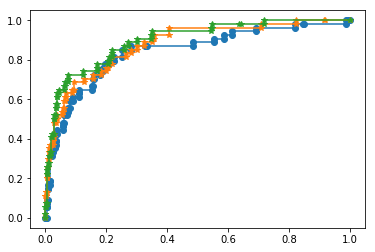

In [6]:
plt.plot(L1[0], L2[0], marker = 'o') 
plt.plot(L1[1], L2[1], marker = '*') 
plt.plot(L1[2], L2[2], marker = '*') 
plt.show()

The selection of base model will affect the effect of voting model, and it is difficult to determine which base model can make voting model achieve good effect, which needs to be tested in the experiment.

In [7]:
# 三个基学习器
log_clf1 = LogisticRegression(penalty='l2')
log_clf2 = LogisticRegression(penalty='l1')
log_clf3 = LogisticRegression(C=0.1)
log_clf4 = LogisticRegression(C=0.01)


# 投票分类器，基分类器一样，只是参数不一样
voting_clf1 = VotingClassifier( estimators=[("lr1", log_clf1),("lr2", log_clf2),("lr3", log_clf3) ], voting='soft' )
voting_clf2 = VotingClassifier( estimators=[("lr1", log_clf2),("lr2", log_clf3),("lr3", log_clf4) ], voting='soft' )
voting_clf3 = VotingClassifier( estimators=[("lr1", log_clf3),("lr2", log_clf4),("lr3", log_clf1) ], voting='soft' )

# 假正率、真正率
L1 = []
L2 = []

for clf in (voting_clf1,voting_clf2, voting_clf3):
    clf.fit( X_train, y_train )
    y_pred = clf.predict( X_test )
    print(clf.__class__.__name__,'accuracy is ', accuracy_score(y_test, y_pred) )
    
    y_score = clf.predict_proba(X_test)[:, 1]   
    print(clf.__class__.__name__, 'auc is ', roc_auc_score(y_test,y_score))
    
    L1.append(roc_curve(y_test, y_score)[0])
    L2.append(roc_curve(y_test, y_score)[1])

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWar

VotingClassifier accuracy is  0.9250985545335085
VotingClassifier auc is  0.6707004033736708


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarni

VotingClassifier accuracy is  0.9250985545335085
VotingClassifier auc is  0.6751008434176751


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


VotingClassifier accuracy is  0.9250985545335085
VotingClassifier auc is  0.6708837550421709


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


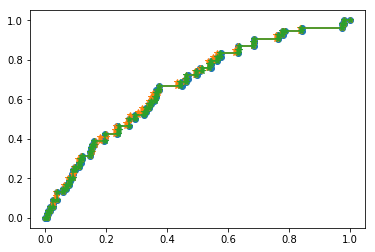

In [8]:
plt.plot(L1[0], L2[0], marker = 'o') 
plt.plot(L1[1], L2[1], marker = '*') 
plt.plot(L1[2], L2[2], marker = '*') 
plt.show()

It can be concluded from the above experiment that the change of base model parameters has little effect on the effect of voting model.The effect of the voting model is poor, because the base model is the same model with different parameters and insufficient diversity.

# Defferent train/test data split ratio

In [9]:
log_clf = LogisticRegression()
rf_clf = RandomForestClassifier()
svm_clf = SVC(probability=True)

# 投票分类器
voting_clf = VotingClassifier( estimators=[("lr", log_clf), ("rf", rf_clf), ("svc", svm_clf)], voting='soft' )

# 假正率、真正率
L1 = []
L2 = []

# 比较不同数据划分比例对投票分类器最终效果的影响
for test_size in [0.2, 0.3, 0.4, 0.5]:
    X_train, X_test, y_train, y_test = train_test_split(\
                        data, label, test_size=test_size, random_state=22)
    voting_clf.fit( X_train, y_train )
    
    y_pred = voting_clf.predict( X_test )
    print('test size is', test_size, 'accuracy is ', accuracy_score(y_test, y_pred) )
    
    y_score = clf.predict_proba(X_test)[:, 1]   
    print('test size is', test_size, 'auc is ', roc_auc_score(y_test,y_score))
    
    L1.append(roc_curve(y_test, y_score)[0])
    L2.append(roc_curve(y_test, y_score)[1])

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


test size is 0.2 accuracy is  0.9329388560157791
test size is 0.2 auc is  0.647618455415993


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


test size is 0.3 accuracy is  0.9290407358738502
test size is 0.3 auc is  0.6708837550421709


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


test size is 0.4 accuracy is  0.9289940828402367
test size is 0.4 auc is  0.6840941259731069


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


test size is 0.5 accuracy is  0.930544593528019
test size is 0.5 auc is  0.6995431413370345


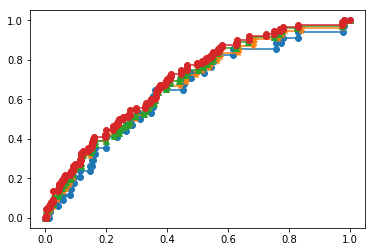

In [10]:
plt.plot(L1[0], L2[0], marker = 'o') 
plt.plot(L1[1], L2[1], marker = '*') 
plt.plot(L1[2], L2[2], marker = '^') 
plt.plot(L1[3], L2[3], marker = 'o') 
plt.show()

It can be seen from the above experiment that when test_size increases, both accuracy and AUC increase, indicating that different proportions of training set and test set will affect the effect of the final model.

